# Import libs

In [1]:
import datetime

import numpy as np 
import pandas as pd

from scipy import stats
from skmultiflow.drift_detection import KSWIN

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from functools import reduce
import statsmodels.stats.api as sms

matplotlib.rcParams['figure.figsize'] = (20, 8)

In [2]:
odi_sorted_df = pd.read_excel("odi_sorted.xlsx", parse_dates=[9])
odi_sorted_df.columns = ['Team', 'Runs', 'Wkts', 'Balls', 'Ave', 'RPO', 'Result', 'Opposition','Ground', 'Date']
odi_sorted_df.sort_values("Date", ascending=True, inplace=True,ignore_index=True)
odi_sorted_df.head()

,Team,Runs,Wkts,Balls,Ave,RPO,Result,Opposition,Ground,Date
0,Australia,191,5,278,38.2,4.12,won,v England,Melbourne,1971-01-05
1,England,190,10,316,19,3.6,lost,v Australia,Melbourne,1971-01-05
2,England,226,4,295,56.5,4.59,won,v Australia,Manchester,1972-08-24
3,Australia,222,8,330,27.75,4.03,lost,v England,Manchester,1972-08-24
4,Australia,240,5,309,48,4.66,won,v England,Lord's,1972-08-26


# Visualize time-series data

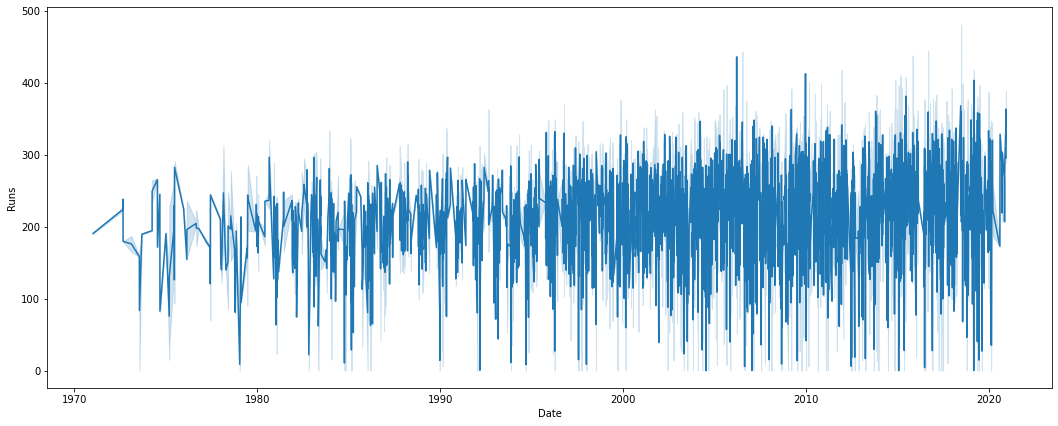

In [3]:
fig, ax = plt.subplots(figsize=(18, 7))
fig = sns.lineplot(x="Date", y="Runs",data=odi_sorted_df)
plt.show()

## Yearly average

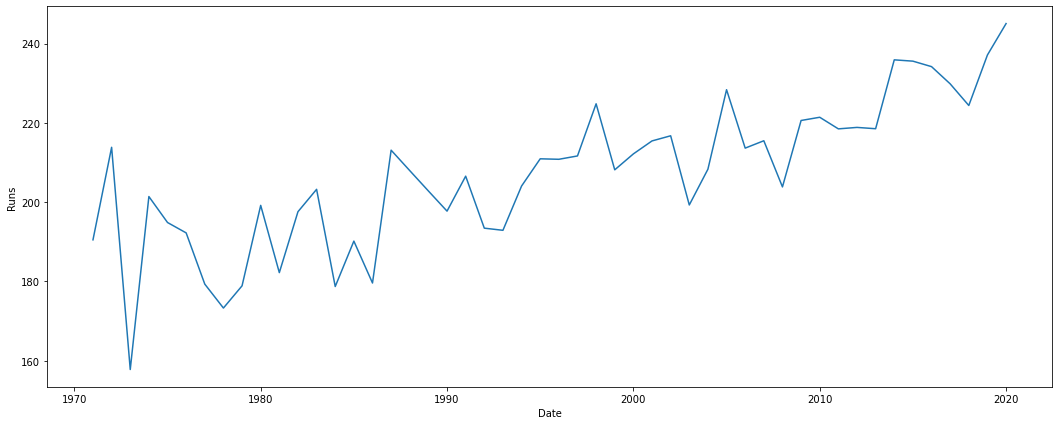

In [4]:
# yearly avg
df = odi_sorted_df.copy()
yearly_avg = df.groupby(df.Date.dt.year)['Runs'].mean()

fig, ax = plt.subplots(figsize=(18, 7))
fig = sns.lineplot(x=yearly_avg.index, y=yearly_avg)
plt.show()

# Prepare baseline(year<2010) and target(year>2010) dataset

In [5]:
baseline_df = odi_sorted_df.loc[odi_sorted_df["Date"] < "2011-01-01"] # & (df["Date"] < "2000-01-01")
baseline_df.head()

,Team,Runs,Wkts,Balls,Ave,RPO,Result,Opposition,Ground,Date
0,Australia,191,5,278,38.2,4.12,won,v England,Melbourne,1971-01-05
1,England,190,10,316,19,3.6,lost,v Australia,Melbourne,1971-01-05
2,England,226,4,295,56.5,4.59,won,v Australia,Manchester,1972-08-24
3,Australia,222,8,330,27.75,4.03,lost,v England,Manchester,1972-08-24
4,Australia,240,5,309,48,4.66,won,v England,Lord's,1972-08-26


In [6]:
target_df = odi_sorted_df.loc[odi_sorted_df["Date"] > "2011-01-01"] # & (df["Date"] < "2000-01-01")
target_df.head()

,Team,Runs,Wkts,Balls,Ave,RPO,Result,Opposition,Ground,Date
6156,India,154,10,214,15.4,4.31,lost,v South Africa,Durban,2011-01-12
6157,South Africa,289,9,300,32.11,5.78,won,v India,Durban,2011-01-12
6158,South Africa,189,10,258,18.9,4.39,lost,v India,Johannesburg,2011-01-15
6159,India,190,10,284,19,4.01,won,v South Africa,Johannesburg,2011-01-15
6160,England,294,10,298,29.4,5.91,lost,v Australia,Melbourne,2011-01-16


# Technique 1 : Recommended Threshold (Inter-quartile range)

In [7]:
start_year=2010
end_year=2021

start = start_year + 1
rts = []

#baseline
desc = baseline_df["Runs"].describe()
rt = desc["75%"] + 1.5 * (desc["75%"] - desc["25%"])
rts.append(["1971-01-01 / 2010-01-01", rt])

#target
desc = target_df["Runs"].describe()
rt = desc["75%"] + 1.5 * (desc["75%"] - desc["25%"])
rts.append(["2011-01-01 / 2020-01-01", rt])

# target batch
for i in np.arange(start,end_year):
    target_frm = f"{i}-01-01"
    target_to = f"{i+1}-01-01"

    baseline = baseline_df["Runs"]
    target = target_df.loc[(target_df["Date"] > target_frm) & (target_df["Date"] < target_to)].iloc[:,1]

    row=[]
    if len(target) > 0 and len(baseline) > 0:
        desc = target.describe()
        rt = desc["75%"] + 1.5 * (desc["75%"] - desc["25%"])
        row = [(target_frm + " / " + target_to), rt ]
        rts.append(row)
        
rts_df = (pd.DataFrame(rts, columns=["Period", "Recommended_Threshold"])).set_index(["Period"])
rts_df

,Recommended_Threshold
Period,
1971-01-01 / 2010-01-01,367.500
2011-01-01 / 2020-01-01,414.500
2011-01-01 / 2012-01-01,386.625
2012-01-01 / 2013-01-01,361.750
2013-01-01 / 2014-01-01,398.000
2014-01-01 / 2015-01-01,376.500
2015-01-01 / 2016-01-01,438.500
2016-01-01 / 2017-01-01,427.125
2017-01-01 / 2018-01-01,440.750


# Technique 2: Null Hypothesis testing using KS-test

In [8]:
df = odi_sorted_df.copy()
start_year=2010
end_year=2021

start = start_year + 1
drift = []

#target 
baseline = baseline_df["Runs"]
target = target_df["Runs"]
stat = stats.ks_2samp(baseline, target,mode='asymp')
row = [("2011-01-01" + " / " + "2020-01-01"), "No" if stat.pvalue > 0.05 else "Yes", stat.pvalue ]
drift.append(row)

for i in np.arange(start,end_year):
    target_frm = f"{i}-01-01"
    target_to = f"{i+1}-01-01"

    baseline = baseline_df["Runs"]
    target = target_df.loc[(target_df["Date"] > target_frm) & (target_df["Date"] < target_to)]

    row=[]
    if len(target) > 0 and len(baseline) > 0:
        stat = stats.ks_2samp(baseline, target.iloc[:,1],mode='asymp')
        row = [(target_frm + " / " + target_to), "No" if stat.pvalue > 0.05 else "Yes", stat.pvalue ]
        drift.append(row)
        
drift_df = (pd.DataFrame(drift, columns=["Target", "Is_significant", "P-value"])).set_index(["Target"])
drift_df

,Is_significant,P-value
Target,,
2011-01-01 / 2020-01-01,Yes,1.876619e-40
2011-01-01 / 2012-01-01,Yes,7.459042e-03
2012-01-01 / 2013-01-01,Yes,7.435790e-04
2013-01-01 / 2014-01-01,Yes,7.703679e-04
2014-01-01 / 2015-01-01,Yes,1.607034e-12
2015-01-01 / 2016-01-01,Yes,5.642755e-11
2016-01-01 / 2017-01-01,Yes,1.088291e-10
2017-01-01 / 2018-01-01,Yes,1.969489e-08
2018-01-01 / 2019-01-01,Yes,1.449106e-04


# Technique 3 : Effort esstimation using Confidence intervals

In [9]:
def confidence_interval(series):
       return sms.DescrStatsW(series).tconfint_mean()

start_year=2010
end_year=2021
cis = []

ci=confidence_interval(baseline_df["Runs"].values)
cis.append(["1971-01-01 / 2010-01-01", ci[0], ci[1]])

start = start_year + 1

for i in np.arange(start,end_year):
    target_frm = f"{i}-01-01"
    target_to = f"{i+1}-01-01"

    baseline = baseline_df["Runs"]
    target = target_df.loc[(target_df["Date"] > target_frm) & (target_df["Date"] < target_to)].iloc[:,1]

    row=[]
    if len(target) > 0 and len(baseline) > 0:
        ci = confidence_interval(target)
        row = [(target_frm + " / " + target_to), ci[0], ci[1] ]
        cis.append(row)
        
ci_df = (pd.DataFrame(cis, columns=["Period", "Ci_lower", "Ci_upper"])).set_index(["Period"])
ci_df

,Ci_lower,Ci_upper
Period,,
1971-01-01 / 2010-01-01,206.642874,209.772656
2011-01-01 / 2012-01-01,210.533405,226.432349
2012-01-01 / 2013-01-01,208.767266,228.932734
2013-01-01 / 2014-01-01,209.737836,227.298929
2014-01-01 / 2015-01-01,228.202495,244.114172
2015-01-01 / 2016-01-01,226.586408,244.530030
2016-01-01 / 2017-01-01,223.145073,245.208462
2017-01-01 / 2018-01-01,220.198327,239.476091
2018-01-01 / 2019-01-01,215.490046,233.267767


C:\Users\I301903\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Period'>

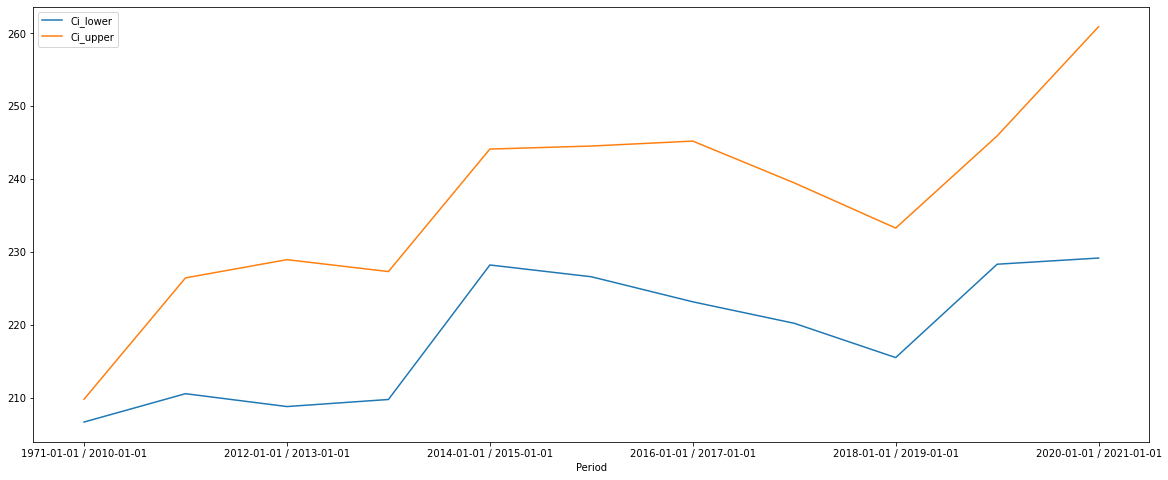

In [10]:
ci_df.plot()

# Visualize : Distribution plots for baseline vs target

<AxesSubplot:xlabel='Runs', ylabel='Probability'>

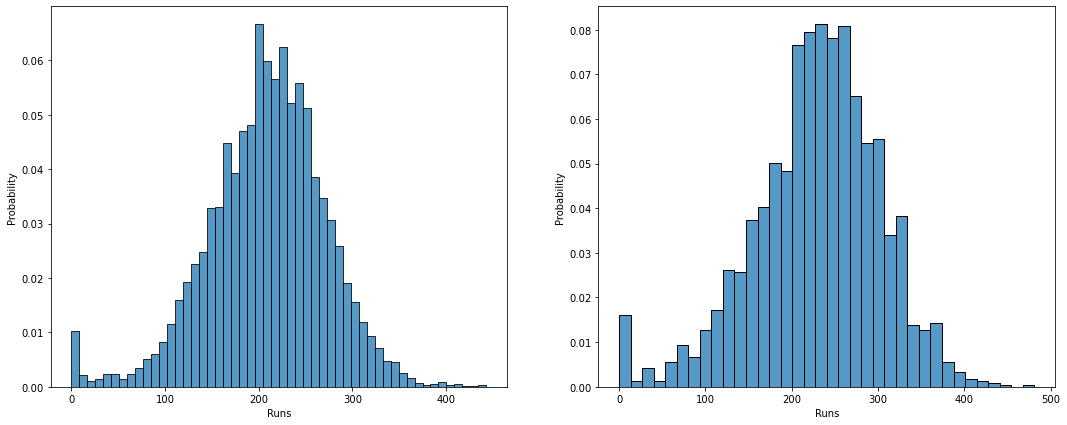

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(18, 7))
sns.histplot(x=baseline_df["Runs"], ax=ax1, stat='probability')
sns.histplot(x=target_df["Runs"], ax=ax2, stat='probability')

In [16]:
baseline = np.random.randint(10, size=30)
target = np.random.randint(10, size=30)

[Text(0.5, 1.0, 'Data Distribution for the current day, "Monday"'),
 Text(0.5, 0, 'Job Start Delay (min)')]

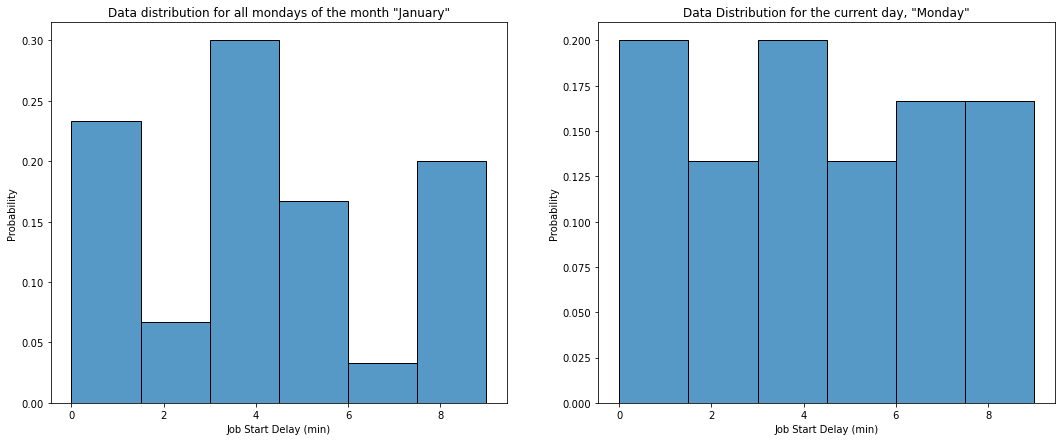

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(18, 7))
sns.histplot(x=baseline, ax=ax1, stat='probability').set(title='Data distribution for all mondays of the month "January"', xlabel="Job Start Delay (min)")
sns.histplot(x=target, ax=ax2, stat='probability').set(title='Data Distribution for the current day, "Monday"', xlabel="Job Start Delay (min)")